<h2>Introduction</h2>

In this notebook i will be showcasing different neural network architectures being tested on the CIFAR10 dataset. I will create a plain deep neural network(multilayer perceptron) as a baseline model. Then i will compare it's results with different convolutional neural network architectures. Also i will create a residual convolutional neural network where we expect to see an improvement on the performance compared to the plain convolutional neural networks. Furthermore i will be incorporating some data augmentation to create more diverse training and decrease the overfitting capabilities of the models. CIFAR10 comes pre splited with a train dataset and a test dataset. Because the goal is to demostrate how different neural network architectures compare with each other i will be using the train dataset for training and the test dataset for validation during the training. For the statistics i will be saving the average of 3 best accuracies achieved in a 30 epoch period.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
# Load the dataset
file_location = "datasets/CIFAR10"

train_dataset = CIFAR10(root=file_location, download=True, train=True, transform=tt.ToTensor())
test_dataset = CIFAR10(root=file_location, download=True, train=False, transform=tt.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Helper functions and class to load data and models to the GPU
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [4]:
batch_size = 100

# Dataloaders for the datasets
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

device = get_device()
# Create data loaders for the GPU if available
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [5]:
# Function for calculating the accuracy
def accuracy(preds, labels):
    _, probs = torch.max(preds, dim=1)
    return torch.sum(probs == labels).item() / len(labels)


# Function for calculating the loss on a batch and a metric if one was given
def batch_loss(model, xb, yb, metric=None, transform=None):
    # Generate batch predictions
    if transform:
        xb = transform(xb)
    preds = model(xb) 
    metric_result = None
    # Calculate a metric if there is one
    if metric:
        metric_result = metric(preds,yb)
    # return Loss, metric and size
    return F.cross_entropy(preds,yb), metric_result, len(xb)


# Function to be used on the validation-test set
def evaluate(model, test_dl, metric=None, test_transform=None):
    # Generate predictions
    with torch.no_grad():
        results = [batch_loss(model,xb,yb,metric,test_transform) for xb,yb in test_dl]
        v_loss, v_metric, size = zip(*results)
    # return validation loss, validation accuracy and batch size
    return v_loss, v_metric, size

In [6]:
# Function to train a model, returns some statistics of the training
def fit(epochs, model, train_dl, test_dl, lr, wd, grad_clip=None, opt=None,
        train_transform=None, test_transform=None, verbose=False):
    # Define an optimizer if none was given
    if not opt:
        opt = torch.optim.Adam
    opt = opt(model.parameters(), lr=lr, weight_decay=wd)
    
    # Lists for some statistics
    train_loss = []
    valid_loss = []
    valid_accuracy = []
    
    for epoch in range(epochs):
        # Start training
        model.train()
        for xb,yb in train_dl:
            # Transform the data if needed
            loss,_,_ = batch_loss(model, xb, yb, transform=train_transform)
            # Calculate the gradients
            loss.backward()
            
            # Gradient clip
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            opt.step()
            opt.zero_grad()
            
        # Start evaluation
        v_loss, v_acc, size = evaluate(model,test_dl,accuracy,test_transform)
        total = np.sum(size)
        avg_v_loss = np.sum(np.multiply(v_loss,size))/total
        avg_v_acc = np.sum(np.multiply(v_acc,size))/total
        # Save statistics (train loss, avg loss and avg accuracy across batches)
        train_loss.append(loss)
        valid_loss.append(avg_v_loss)
        valid_accuracy.append(avg_v_acc)
        if verbose:
            print("Epoch [{}/{}], train_loss: {:.4f}, valid_loss: {:.4f}, valid_acc: {:.4f}"
                    .format(epoch+1, epochs, loss, avg_v_loss, avg_v_acc))
    
    # Return train loss, validation loss and validation accuracy per epoch
    return train_loss, valid_loss, valid_accuracy

In [7]:
# Function that plots the train loss, validation loss and validation accuracy
def show_stats(stats,name):
    fig, ax = plt.subplots(1,2,figsize=(15,6))
    fig.suptitle("Statistics for {}".format(name), fontsize=14)
    ax[0].plot(stats[name]["tL"], label="Train_loss", marker="o", markersize=4)
    ax[0].plot(stats[name]["vL"], label="Valid_loss", marker="^", markersize=4)
    ax[1].plot(stats[name]["vAcc"], label="Valid_accuracy")
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    plt.show()

In [8]:
# Calculate the mean and the std of the channels for normalization
temp_dl = DataLoader(train_dataset, batch_size=len(train_dataset))
imgs, label = next(iter(temp_dl))
reds_mean = imgs[:,0,:,:].mean()
blues_mean = imgs[:,1,:,:].mean()
greens_mean = imgs[:,2,:,:].mean()
reds_std = imgs[:,0,:,:].std()
blues_std = imgs[:,1,:,:].std()
greens_std = imgs[:,2,:,:].std()

stats = ((reds_mean,blues_mean,greens_mean),(reds_std,blues_std,greens_std))
# Transformers for the dataset
train_transform = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode="reflect"),
                              tt.RandomHorizontalFlip(),
                              tt.Normalize(*stats)])
test_transform = tt.Compose([tt.Normalize(*stats)])

In [9]:
# Dictionary that will contain the performance of each model
# The format will be { "name of the model": {"training_loss": t_loss,
#                                            "valid_loss": v_loss,
#                                            "accuracy": acc
#                                            "parameters": par} }

models_statistics = {}
statistics = pd.DataFrame(columns=["Name","Train_Loss","Valid_Loss","Accuracy","Training_time","Comments"])

In [10]:
# Helper function to get the max n values out of an array
def avg_max(x,n):
    sorted_indices = np.argsort(x)
    sorted_arr = np.array(x)[sorted_indices]
    return np.mean(sorted_arr[-n:])

In [11]:
def save_stats(statistics,models_statistics,modelname, tL, vL, vAcc, trt, comment):
    statistics = statistics.append({"Name" : modelname, 
                                "Train_Loss" : tL[-1].item(),
                                "Valid_Loss" : vL[-1].item(),
                                "Accuracy" : avg_max(vAcc,3),
                                "Training_time" : trt,
                                "Comments" : comment
                               }, ignore_index=True)
    
    models_statistics[modelname] = {"tL": tL, "vL": vL, "vAcc": vAcc}
    
    return statistics.drop_duplicates()

In [12]:
# Helper function for convolutional block
def conv_2d(in_channels, out_channels, stride=1, ks=3, padding=1, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
              nn.ReLU(),
              nn.BatchNorm2d(out_channels)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

<h3><u>Evaluation of different models on the dataset</u><h3>

<h2>Multilayer Perceptron</h2>

In [50]:
multi_perc = nn.Sequential(
    
    nn.Flatten(),
    nn.Linear(3072,1000),
    nn.ReLU(),
    nn.BatchNorm1d(1000),
    
    nn.Linear(1000,1000),
    nn.ReLU(),
    nn.BatchNorm1d(1000),
    
    nn.Linear(1000,1000),
    nn.ReLU(),
    nn.BatchNorm1d(1000),
    
    nn.Linear(1000,1000),
    nn.ReLU(),
    nn.BatchNorm1d(1000),
    
    nn.Linear(1000,1000),
    nn.ReLU(),
    nn.BatchNorm1d(1000),
    
    nn.Linear(1000,1000),
    nn.ReLU(),
    nn.BatchNorm1d(1000),
    
    nn.Linear(1000,10)
)
multi_perc = to_device(multi_perc, device)

Multilayer perc train time: 41.6582 seconds


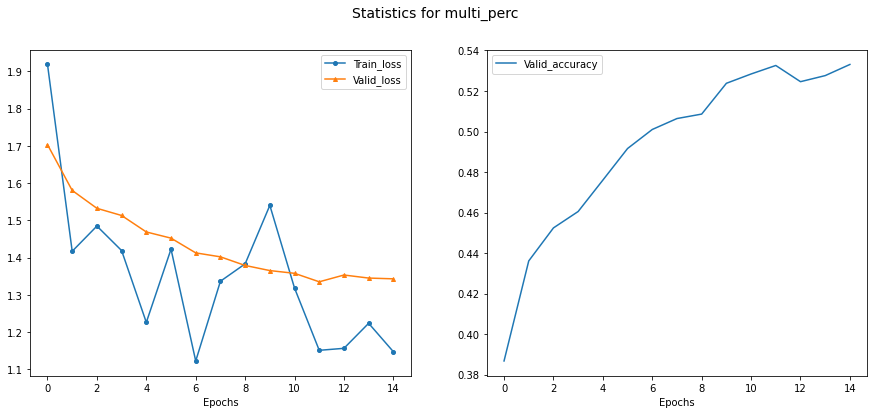

In [51]:
# Train the model and get it's statistics
t1 = time.time()
tL, vL, vAcc = fit(15, multi_perc, train_dl, 
                  test_dl, lr=0.001, wd=1e-4, grad_clip=0.1, verbose=False)
t2 = time.time() - t1
print("Multilayer perc train time:", "{:.4f} seconds".format(t2))
# Save the statistics of the model
statistics = save_stats(statistics,models_statistics,
           "multi_perc", tL, vL, vAcc, t2, "Multilayer perceptron")

# Plot statistics
show_stats(models_statistics, "multi_perc")

<h1>Convolutional Neural Networks</h1>

<h3>Model</h3>
Architecture -> 5 convolutional layers,
                low number of filters(16 mostly),
                stride=1,
                kernel_size=3,
                padding=1,
                without batch normalization

In [52]:
model1 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Flatten(),
    nn.Linear(16,10)
)
# Load model to GPU
model1 = to_device(model1,device)

Epoch [1/15], train_loss: 1.8058, valid_loss: 1.7811, valid_acc: 0.3259
Epoch [2/15], train_loss: 1.6204, valid_loss: 1.6263, valid_acc: 0.3903
Epoch [3/15], train_loss: 1.5695, valid_loss: 1.6246, valid_acc: 0.3956
Epoch [4/15], train_loss: 1.4156, valid_loss: 1.4885, valid_acc: 0.4474
Epoch [5/15], train_loss: 1.8880, valid_loss: 1.4874, valid_acc: 0.4621
Epoch [6/15], train_loss: 1.5248, valid_loss: 1.4234, valid_acc: 0.4824
Epoch [7/15], train_loss: 1.3877, valid_loss: 1.4015, valid_acc: 0.4838
Epoch [8/15], train_loss: 1.1987, valid_loss: 1.3131, valid_acc: 0.5238
Epoch [9/15], train_loss: 1.2600, valid_loss: 1.3253, valid_acc: 0.5141
Epoch [10/15], train_loss: 1.4397, valid_loss: 1.3015, valid_acc: 0.5317
Epoch [11/15], train_loss: 1.2757, valid_loss: 1.3247, valid_acc: 0.5232
Epoch [12/15], train_loss: 1.3881, valid_loss: 1.2459, valid_acc: 0.5526
Epoch [13/15], train_loss: 1.1293, valid_loss: 1.2542, valid_acc: 0.5505
Epoch [14/15], train_loss: 1.1827, valid_loss: 1.2376, valid

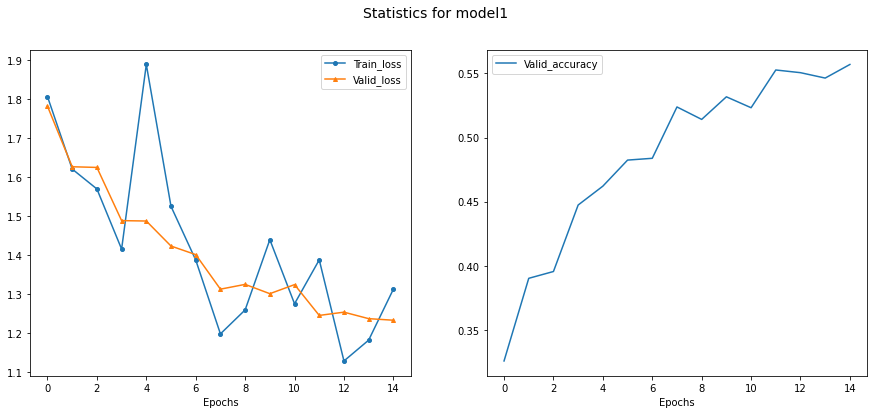

In [53]:
# Train the model and get it's statistics
t1 = time.time()
tL, vL, vAcc = fit(15, model1, train_dl, 
                  test_dl, lr=0.001, wd=1e-4, grad_clip=0.1, verbose=True)
t2 = time.time() - t1
print("Model1 train time:", "{:.4f} seconds".format(t2))
# Save the statistics of the model
statistics = save_stats(statistics,models_statistics,
           "model1", tL, vL, vAcc, t2, "5 conv layers, 16 filters each, without batch")

# Plot statistics
show_stats(models_statistics, "model1")

<h3> Model, same as previous model but with batch normalization</h3>
Architecture -> 5 convolutional layers,
                low number of filters(16 mostly),
                stride=1,
                kernel_size=3,
                padding=1,
                with batch normalization

In [54]:
model1Batch = nn.Sequential(
    conv_2d(3,16,pool=True),
    
    conv_2d(16,16,pool=True),
    
    conv_2d(16,16,pool=True),
    
    conv_2d(16,16,pool=True),
    
    conv_2d(16,16,pool=True),
    
    nn.Flatten(),
    nn.Linear(16,10)
)
# Load model to GPU
model1Batch = to_device(model1Batch,device)

Model1Batch train time: 43.3700 seconds


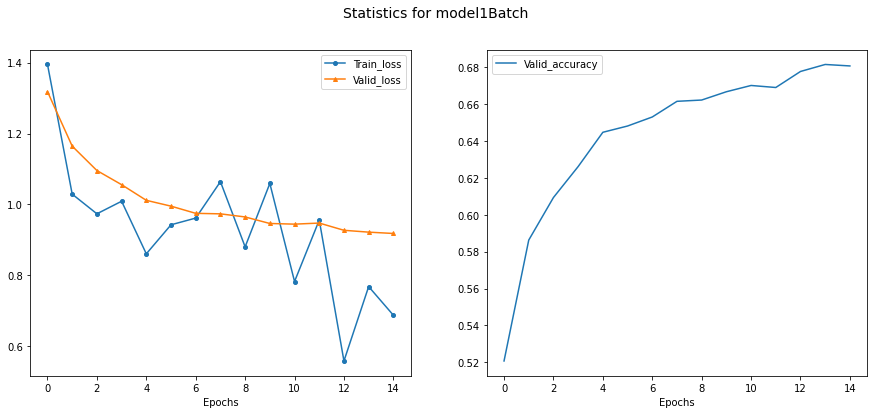

In [55]:
# Train the model and get it's statistics
t1 = time.time()
tL, vL, vAcc = fit(15, model1Batch, train_dl, 
                  test_dl, lr=0.001, wd=1e-4, grad_clip=0.1, verbose=True)
t2 = time.time() - t1
print("Model1Batch train time:", "{:.4f} seconds".format(t2))
# Save the statistics of the model
statistics = save_stats(statistics,models_statistics,
           "model1Batch", tL, vL, vAcc, t2, "5 conv layers, 16 filters each, with batch")

# Plot statistics
show_stats(models_statistics, "model1Batch")

<h2> Model with higher number of filters, without batch normalization </h2>
Architecture -> 5 convolutional layers, filters increase to 384, kernel_size=3, stride=1, padding=1, no batch normalization

In [56]:
model2 = nn.Sequential(

    nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(96, 192, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    
    nn.Flatten(),
    nn.Linear(384,10)
)
model2 = to_device(model2,device)

Epoch [1/15], train_loss: 1.1795, valid_loss: 1.3280, valid_acc: 0.5098
Epoch [2/15], train_loss: 0.9494, valid_loss: 1.1413, valid_acc: 0.5965
Epoch [3/15], train_loss: 1.0846, valid_loss: 1.0187, valid_acc: 0.6408
Epoch [4/15], train_loss: 0.9049, valid_loss: 0.8471, valid_acc: 0.7020
Epoch [5/15], train_loss: 0.7240, valid_loss: 0.8049, valid_acc: 0.7237
Epoch [6/15], train_loss: 0.7135, valid_loss: 0.7539, valid_acc: 0.7402
Epoch [7/15], train_loss: 0.5936, valid_loss: 0.7944, valid_acc: 0.7317
Epoch [8/15], train_loss: 0.7265, valid_loss: 0.7967, valid_acc: 0.7377
Epoch [9/15], train_loss: 0.5193, valid_loss: 0.7732, valid_acc: 0.7516
Epoch [10/15], train_loss: 0.5104, valid_loss: 0.8161, valid_acc: 0.7366
Epoch [11/15], train_loss: 0.4233, valid_loss: 0.8094, valid_acc: 0.7426
Epoch [12/15], train_loss: 0.4985, valid_loss: 0.7938, valid_acc: 0.7608
Epoch [13/15], train_loss: 0.4207, valid_loss: 0.8904, valid_acc: 0.7499
Epoch [14/15], train_loss: 0.2031, valid_loss: 0.9008, valid

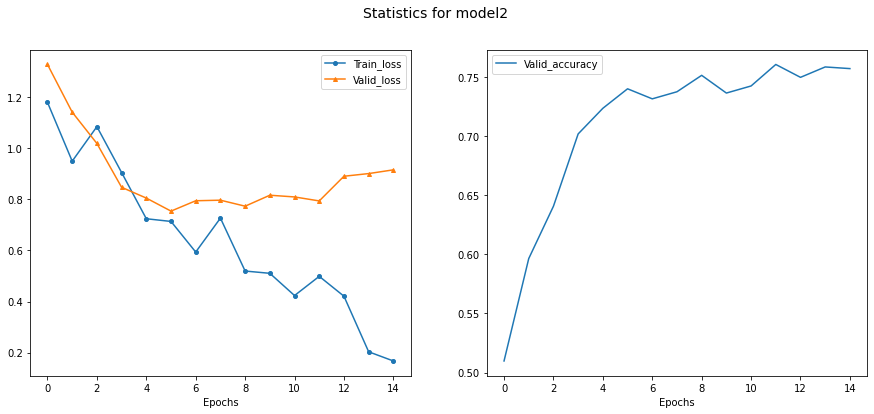

In [57]:
# Train the model and get it's statistics
t1 = time.time()
tL, vL, vAcc = fit(15, model2, train_dl, 
                  test_dl, lr=0.001, wd=1e-4, verbose=True)
t2 = time.time() - t1
print("Model2 train time:", "{:.4f} seconds".format(t2))
# Save model statistics
statistics = save_stats(statistics,models_statistics,
           "model2", tL, vL, vAcc, t2, "5 conv layers, high number of filters, without batch")

# Plot statistics
show_stats(models_statistics, "model2")

<h2>Same model as previous but with batch normalization</h2>
Architecture -> 5 convolutional layers, filters increase to 384, kernel_size=3, stride=1, padding=1, with batch normalization

In [58]:
model2Batch1 = nn.Sequential(
    conv_2d(3,96,pool=True),
    
    conv_2d(96,192,pool=True),
    
    conv_2d(192,384,pool=True),
    
    conv_2d(384,384,pool=True),
    
    conv_2d(384,384,pool=True),
    
    nn.Flatten(),
    nn.Linear(384,10)
)
# Load model to GPU
model2Batch1 = to_device(model2Batch1,device)

Epoch [1/15], train_loss: 0.7728, valid_loss: 0.8073, valid_acc: 0.7168
Epoch [2/15], train_loss: 0.4504, valid_loss: 0.6573, valid_acc: 0.7777
Epoch [3/15], train_loss: 0.3701, valid_loss: 0.6085, valid_acc: 0.7959
Epoch [4/15], train_loss: 0.3860, valid_loss: 0.6208, valid_acc: 0.7959
Epoch [5/15], train_loss: 0.2899, valid_loss: 0.6642, valid_acc: 0.8017
Epoch [6/15], train_loss: 0.2221, valid_loss: 0.7133, valid_acc: 0.8033
Epoch [7/15], train_loss: 0.1759, valid_loss: 0.8101, valid_acc: 0.7932
Epoch [8/15], train_loss: 0.1569, valid_loss: 0.7669, valid_acc: 0.8041
Epoch [9/15], train_loss: 0.1225, valid_loss: 0.8387, valid_acc: 0.7977
Epoch [10/15], train_loss: 0.0831, valid_loss: 0.8032, valid_acc: 0.8027
Epoch [11/15], train_loss: 0.1185, valid_loss: 0.8289, valid_acc: 0.8023
Epoch [12/15], train_loss: 0.1124, valid_loss: 0.8505, valid_acc: 0.7969
Epoch [13/15], train_loss: 0.0724, valid_loss: 0.8373, valid_acc: 0.8054
Epoch [14/15], train_loss: 0.0428, valid_loss: 0.8717, valid

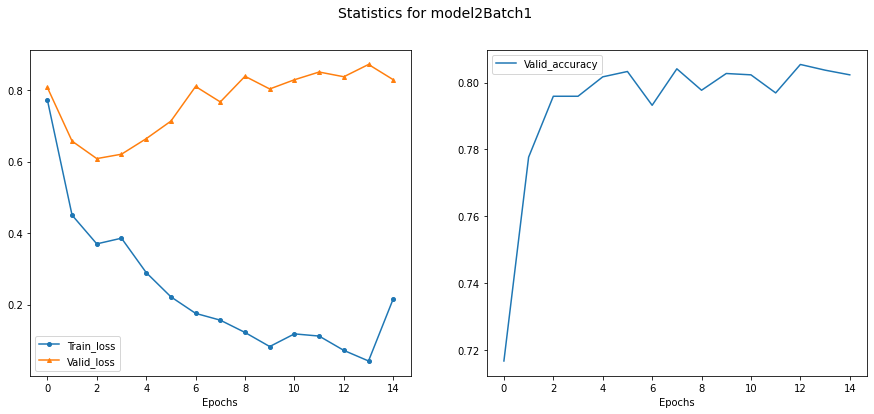

In [59]:
# Train model and get it's statistics
t1 = time.time()
tL, vL, vAcc = fit(15, model2Batch1, train_dl, 
                  test_dl, lr=0.001, wd=1e-4, verbose=True)
t2 = time.time() - t1
print("Model2Batch1 train time:", "{:.4f} seconds".format(t2))
# Save model statistics
statistics = save_stats(statistics,models_statistics,
           "model2Batch1", tL, vL, vAcc, t2, "5 conv layers, high number of filters, with batch")

# Plot statistics
show_stats(models_statistics, "model2Batch1")

<h2>Same model as previous but this time we use transformations for the data</h2>
Architecture -> 5 convolutional layers, filters increase to 384, kernel_size=3, stride=1, padding=1, with batch normalization, transformations for the data

In [14]:
model2Batch2 = nn.Sequential(
    conv_2d(3,96,pool=True),
    
    conv_2d(96,192,pool=True),
    
    conv_2d(192,384,pool=True),
    
    conv_2d(384,384,pool=True),
    
    conv_2d(384,384,pool=True),
    
    nn.Flatten(),
    nn.Linear(384,10)
)
# Load model to GPU
model2Batch2 = to_device(model2Batch2,device)

Epoch [1/35], train_loss: 1.0493, valid_loss: 0.8488, valid_acc: 0.7003
Epoch [2/35], train_loss: 0.6656, valid_loss: 0.6779, valid_acc: 0.7670
Epoch [3/35], train_loss: 0.6230, valid_loss: 0.6038, valid_acc: 0.7897
Epoch [4/35], train_loss: 0.7531, valid_loss: 0.5324, valid_acc: 0.8143
Epoch [5/35], train_loss: 0.4107, valid_loss: 0.5030, valid_acc: 0.8272
Epoch [6/35], train_loss: 0.3201, valid_loss: 0.4947, valid_acc: 0.8305
Epoch [7/35], train_loss: 0.4800, valid_loss: 0.4969, valid_acc: 0.8301
Epoch [8/35], train_loss: 0.5252, valid_loss: 0.4421, valid_acc: 0.8519
Epoch [9/35], train_loss: 0.3215, valid_loss: 0.4475, valid_acc: 0.8464
Epoch [10/35], train_loss: 0.1975, valid_loss: 0.4440, valid_acc: 0.8512
Epoch [11/35], train_loss: 0.5065, valid_loss: 0.4380, valid_acc: 0.8534
Epoch [12/35], train_loss: 0.3858, valid_loss: 0.4382, valid_acc: 0.8518
Epoch [13/35], train_loss: 0.4514, valid_loss: 0.4188, valid_acc: 0.8559
Epoch [14/35], train_loss: 0.3891, valid_loss: 0.3952, valid

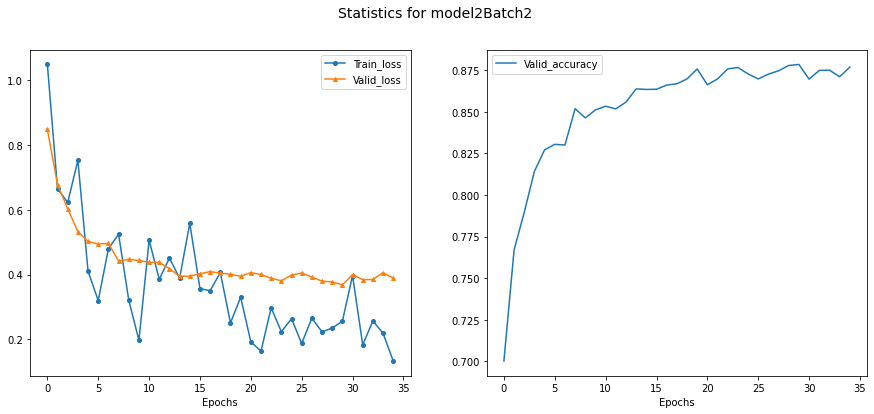

In [15]:
# Train model and get statistics
t1 = time.time()
tL, vL, vAcc = fit(35, model2Batch2, train_dl, 
                   test_dl, lr=0.001, wd=1e-4,
                   train_transform=train_transform, test_transform=test_transform,
                   verbose=True)
t2 = time.time() - t1
print("Model2Batch2 train time:", "{:.4f} seconds".format(t2))
# Save model statistics
statistics = save_stats(statistics,models_statistics,
                        "model2Batch2", tL, vL, vAcc, t2, 
                        "5 conv layers, high number of filters, with batch and transformations")

# Plot model statistics
show_stats(models_statistics, "model2Batch2")

<h2>Deep convolutional neural network</h2>

In [63]:
deep_conv = nn.Sequential(
    conv_2d(3, 128),
    conv_2d(128, 128),
    conv_2d(128, 128, pool=True),
    conv_2d(128, 256),
    conv_2d(256, 256),
    conv_2d(256, 256, pool=True),
    conv_2d(256, 512),
    conv_2d(512, 512),
    conv_2d(512, 512, pool=True),
    conv_2d(512, 1024),
    conv_2d(1024, 1024),
    conv_2d(1024, 1024, pool=True),
    conv_2d(1024, 1024, pool=True),
    nn.Flatten(),
    nn.Linear(1024,1024),
    nn.Linear(1024,10)
)
deep_conv = to_device(deep_conv, device)

Epoch [1/15], train_loss: 1.7480, valid_loss: 1.4648, valid_acc: 0.4672
Epoch [2/15], train_loss: 1.1861, valid_loss: 1.1253, valid_acc: 0.5883
Epoch [3/15], train_loss: 0.8824, valid_loss: 0.9165, valid_acc: 0.6850
Epoch [4/15], train_loss: 0.7575, valid_loss: 0.7710, valid_acc: 0.7336
Epoch [5/15], train_loss: 0.6335, valid_loss: 0.6497, valid_acc: 0.7869
Epoch [6/15], train_loss: 0.6778, valid_loss: 0.5861, valid_acc: 0.8057
Epoch [7/15], train_loss: 0.5989, valid_loss: 0.5660, valid_acc: 0.8157
Epoch [8/15], train_loss: 0.5729, valid_loss: 0.5250, valid_acc: 0.8309
Epoch [9/15], train_loss: 0.4446, valid_loss: 0.4832, valid_acc: 0.8415
Epoch [10/15], train_loss: 0.4007, valid_loss: 0.4592, valid_acc: 0.8514
Epoch [11/15], train_loss: 0.3924, valid_loss: 0.4413, valid_acc: 0.8553
Epoch [12/15], train_loss: 0.4192, valid_loss: 0.4429, valid_acc: 0.8586
Epoch [13/15], train_loss: 0.3155, valid_loss: 0.4155, valid_acc: 0.8680
Epoch [14/15], train_loss: 0.6350, valid_loss: 0.4079, valid

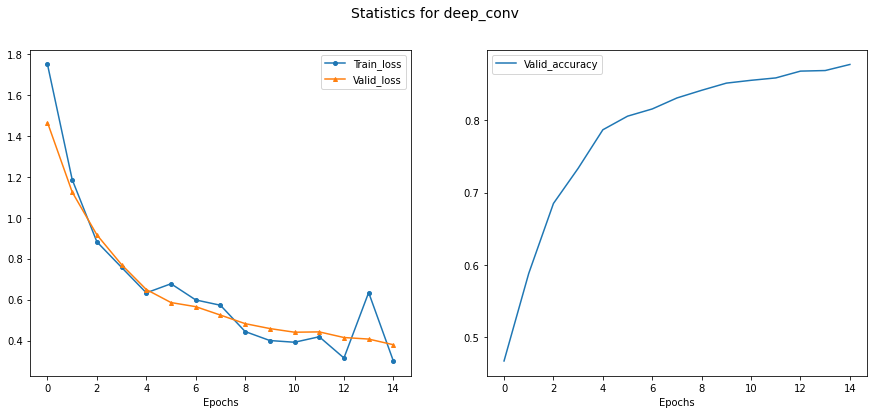

In [64]:
# Train model and get statistics
t1 = time.time()
tL, vL, vAcc = fit(15, deep_conv, train_dl, 
                   test_dl, lr=0.001, wd=1e-4,
                   train_transform=train_transform, test_transform=test_transform,
                   verbose=True)
t2 = time.time() - t1
print("Deep conv train time:", "{:.4f} seconds".format(t2))
# Save model statistics
statistics = save_stats(statistics,models_statistics,
           "deep_conv", tL, vL, vAcc, t2, "deep conv 13 layers, high number of filters(1024), with batch")

# Plot model statistics
show_stats(models_statistics, "deep_conv")

In [65]:
# Load the statistics from resnet14
import pickle
with open("resnet_results.pkl", "rb") as file:
    s = pickle.load(file)
    x = pickle.loads(s)
statistics = statistics.append(x[0], ignore_index=True)
models_statistics["res12"] = {"tL": x[1]["res12"]["tL"],
                              "vL": x[1]["res12"]["vL"],
                              "vAcc": x[1]["res12"]["vAcc"]}

1. multi_perc -> multilayer perceptron
2. model1 -> convolutional neural network with 5 conv layers, 16 filters and no batch normalization
3. model1Batch -> convolutional neural network with 5 conv layers, 16 filters and batch normalization
4. model2 -> convolutional neural network with 5 conv layers, filters increase from 96 to 384, no batch normalization
5. model2Batch1 -> convolutional neural network with 5 conv layers, filters increase from 96 to 384, with batch normalization
6. model2Batch2 -> convolutional neural network with 5 conv layers, filters increase from 96 to 384, with batch normalization and transformations on the data
7. deep_conv -> convolutional neural network with 13 conv layers and 2 linear, with batch normalization and transformations on the data
8. resnet -> residual convolutional neural network with 14 conv layers

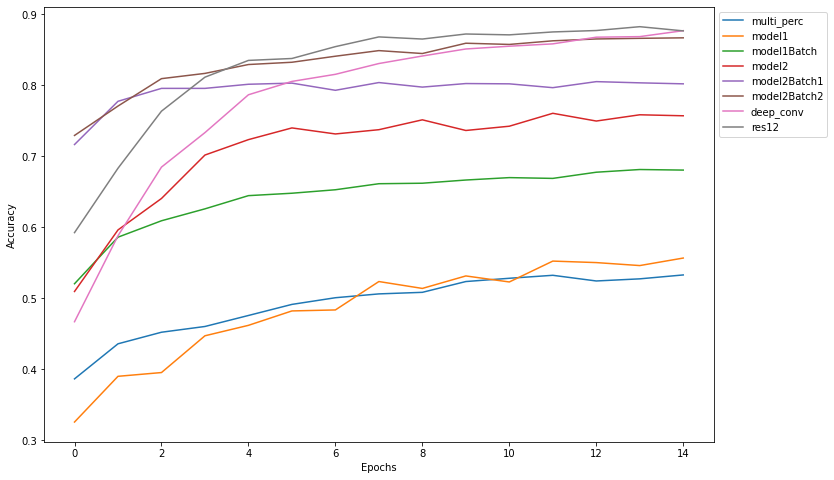

In [70]:
# Plot all the accuracies together
plt.figure(figsize=(12,8))
for model in models_statistics:
    plt.plot(models_statistics[model]["vAcc"], label=model)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

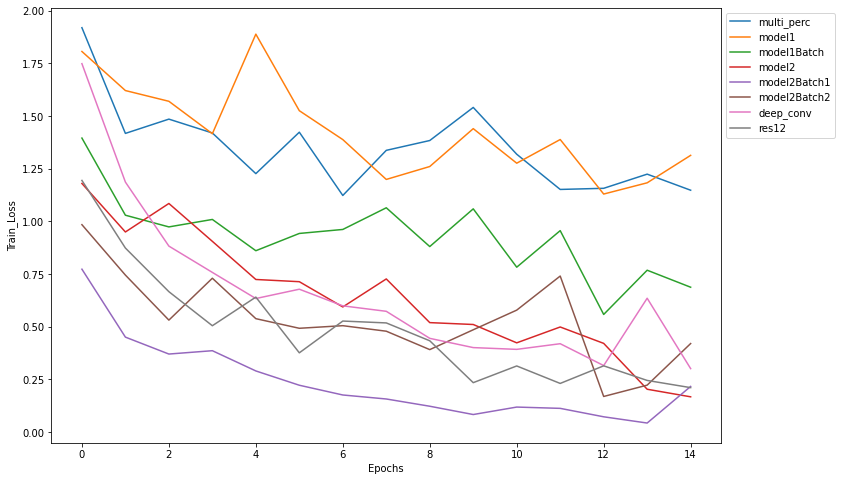

In [67]:
# Plot all train losses together
plt.figure(figsize=(12,8))
for model in models_statistics:
    plt.plot(models_statistics[model]["tL"], label=model)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Train_Loss")
plt.show()

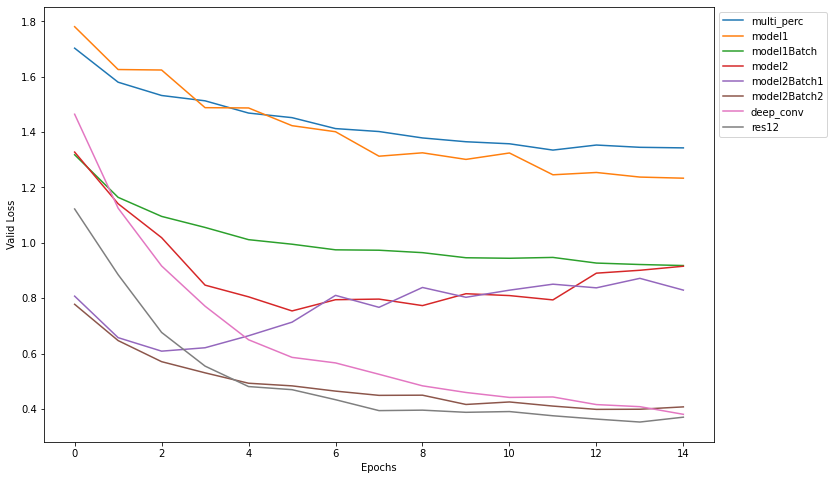

In [68]:
# Plot all valid losses together
plt.figure(figsize=(12,8))
for model in models_statistics:
    plt.plot(models_statistics[model]["vL"], label=model)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Valid Loss")
plt.show()

In [71]:
statistics

,Name,Train_Loss,Valid_Loss,Accuracy,Training_time,Comments
0,multi_perc,1.147488,1.343163,0.531367,41.658153,Multilayer perceptron
1,model1,1.312961,1.233598,0.553333,32.381731,"5 conv layers, 16 filters each, without batch"
2,model1Batch,0.687199,0.917894,0.680067,43.369964,"5 conv layers, 16 filters each, with batch"
3,model2,0.167182,0.915424,0.758933,123.928000,"5 conv layers, high number of filters, without..."
4,model2Batch1,0.216450,0.829110,0.804400,138.836290,"5 conv layers, high number of filters, with batch"
5,model2Batch2,0.419954,0.407130,0.866333,137.337809,"5 conv layers, high number of filters, with ba..."
6,deep_conv,0.300972,0.380244,0.871333,764.729201,"deep conv 13 layers, high number of filters(10..."
7,res12,0.210745,0.369919,0.879033,768.558475,residual conv network with 4 residual units
